In [ ]:
%matplotlib widget

In [ ]:
import pandas as pd

In [ ]:
from nixtlats import TimeGPT
import os
from itertools import product

from dotenv import load_dotenv
from fastcore.test import test_eq, test_fail
from nbdev.showdoc import show_doc
from openbb_terminal.sdk import openbb

load_dotenv()

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

True

In [ ]:
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

In [ ]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df = df.tail(15000)[['Timestamp', 'Close']]
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s') #= df['Timestamp']
df = df.bfill()
df['Timestamp'] = df['Timestamp'].astype(str)

In [ ]:
fcst_df = timegpt.forecast(
    df, h = 24, 
    time_col='Timestamp', target_col='Close', 
    add_history=True,
    level=[80, 90, 95],
)

In [ ]:
df = df.merge(fcst_df)

In [ ]:
df.head()

,Timestamp,Close,TimeGPT,TimeGPT-lo-80,TimeGPT-lo-90,TimeGPT-lo-95,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-hi-95
0,2021-03-20 14:25:00,59303.03,59139.207031,58938.000643,58880.961427,58831.488415,59340.413420,59397.452635,59446.925648
1,2021-03-20 14:26:00,59305.09,59124.234375,58923.027987,58865.988771,58816.515758,59325.440763,59382.479979,59431.952992
2,2021-03-20 14:27:00,59266.78,59117.644531,58916.438143,58859.398927,58809.925915,59318.850920,59375.890135,59425.363148
3,2021-03-20 14:28:00,59215.65,59113.292969,58912.086580,58855.047365,58805.574352,59314.499357,59371.538573,59421.011585
4,2021-03-20 14:29:00,59218.51,59117.582031,58916.375643,58859.336427,58809.863415,59318.788420,59375.827635,59425.300648


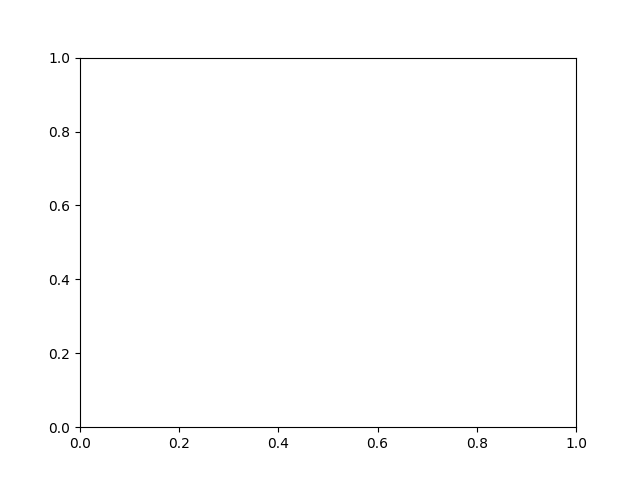

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from random import randint

fig, ax = plt.subplots()

def animate(i):
    min_len = 25
    ax.clear()
    ax.plot(df['Timestamp'].iloc[:i], df['Close'].iloc[:i])
    if i >= 25:
        for level, alpha in zip([80, 90, 95], [0.4, 0.2, 0.1]):
            ax.fill_between(
                df['Timestamp'].iloc[(i-min_len):i], 
                df[f'TimeGPT-lo-{level}'].iloc[(i-min_len):i], 
                df[f'TimeGPT-hi-{level}'].iloc[(i-min_len):i], 
                color='orange', 
                alpha=alpha,
                label=f'TimeGPT-level-{level}]'
            )
    #ax.set_xlim([0,20])
    ax.set_ylim([0,10])

In [ ]:
df['Close'].describe()

count    14976.000000
mean     55691.856975
std       2050.160896
min      50406.640000
25%      54402.080000
50%      55821.815000
75%      57365.457500
max      59683.860000
Name: Close, dtype: float64

In [ ]:
from matplotlib.animation import FFMpegWriter

writer = FFMpegWriter(fps=10, metadata=dict(artist='Me'), bitrate=450)

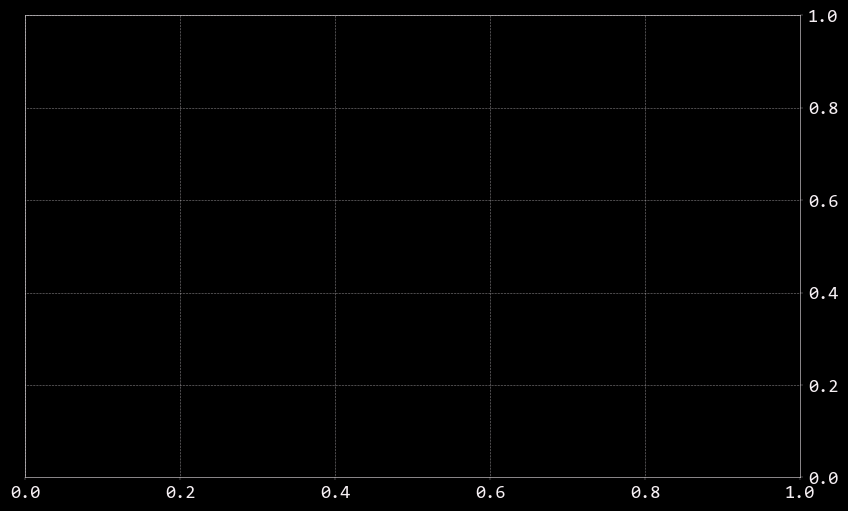

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 6))

def animate(i, str_ticker):
    df = tickers_df.query('unique_id == @str_ticker')
    if i < 20:
        return
    ax.clear()
    
    # Split point for 80% and 20%
    #split_point = int(0.8 * i)
    
    # Plotting the historical (80%) close values
    ax.plot(df['Timestamp'].iloc[:i], df['Close'].iloc[:i], lw=2, color='orange', label='Real Time Data')
    
    # Plotting the forecasted (20%) close values
    #ax.plot(df['Timestamp'].iloc[split_point:i], df['TimeGPT'].iloc[split_point:i], lw=2, color='green', label='Forecast')
    
    # Plotting the filled regions
    if i >= 25:
        for level, alpha in zip([90], [0.2]):
            ax.fill_between(
                df['Timestamp'].iloc[:i], 
                df[f'TimeGPT-lo-{level}'].iloc[:i], 
                df[f'TimeGPT-hi-{level}'].iloc[:i], 
                color='orange', 
                alpha=alpha,
                label=f'TimeGPT bands'
            )

            # Highlight points above or below the levels
            above_level = df['Close'].iloc[:i] > df[f'TimeGPT-hi-{level}'].iloc[:i]
            below_level = df['Close'].iloc[:i] < df[f'TimeGPT-lo-{level}'].iloc[:i]

            ax.scatter(df['Timestamp'].iloc[:i][above_level], df['Close'].iloc[:i][above_level], color='blue', label='Above Level', s=50)
            ax.scatter(df['Timestamp'].iloc[:i][below_level], df['Close'].iloc[:i][below_level], color='green', label='Below Level', s=50)
            
    level = 90
    y_max = df[f'TimeGPT-hi-{level}'].iloc[:i].max() * 1.01  # give a bit of padding
    y_min = df[f'TimeGPT-lo-{level}'].iloc[:i].min() * 0.99
    ax.set_ylim([y_min, y_max])
    
    # Styling
    ax.set_title(f"Close Price Over Time ({str_ticker}) with TimeGPT Levels", fontsize=16)
    ax.set_xlabel("Timestamp", fontsize=14)
    ax.set_ylabel("Close Price", fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc="upper left")
    
    # Timestamp formatting for x-axis
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    # Format the y-axis to have commas
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Eliminate x-axis legends (tick labels)
    ax.set_xticks([])


In [ ]:
from functools import partial

In [ ]:
ani = FuncAnimation(fig, partial(animate, df=df), frames=200, repeat=False)
#plt.tight_layout()
#plt.show()
ani.save("output.mp4", writer=writer)

### more tickers

In [ ]:
tickers_df = []
tickers = ['AMZN', 'AAPL', 'GOOG']
for ticker in tickers:
    df_ticker = openbb.stocks.load(ticker, start_date='2018-09-30').reset_index().rename(columns={'date': 'Timestamp'})[['Timestamp', 'Close']]
    df_ticker.insert(0, 'unique_id', ticker)
    tickers_df.append(df_ticker)
tickers_df = pd.concat(tickers_df)

Loading Daily data for AMZN with starting period 2018-10-01.

Loading Daily data for AAPL with starting period 2018-10-01.

Loading Daily data for GOOG with starting period 2018-10-01.

In [ ]:
tickers_df['Timestamp'] = tickers_df['Timestamp'].astype(str)

In [ ]:
history_tickers = timegpt.forecast(
    tickers_df, h = 24, 
    time_col='Timestamp', target_col='Close', 
    freq='D',
    add_history=True,
    level=[80, 90, 95],
)

In [ ]:
tickers_df = tickers_df.merge(history_tickers)

In [ ]:
df = pd.concat([df, tickers_df])

In [ ]:
tickers_df = df.copy()

In [ ]:
tickers_df = tickers_df.dropna()

In [ ]:
import numpy as np

In [ ]:
tickers_df = tickers_df.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
for str_ticker in ['GOOG']: #tickers_df['unique_id'].unique():
    #frames = len(tickers_df.query('unique_id == @str_ticker'))
    frames = 1_000
    ani = FuncAnimation(fig, partial(animate, str_ticker=str_ticker), frames=frames, repeat=False)
    #plt.tight_layout()
    #plt.show()
    ani.save(f"output_{str_ticker}.mp4", writer=writer)
    print(f'finished {str_ticker}')

finished GOOG


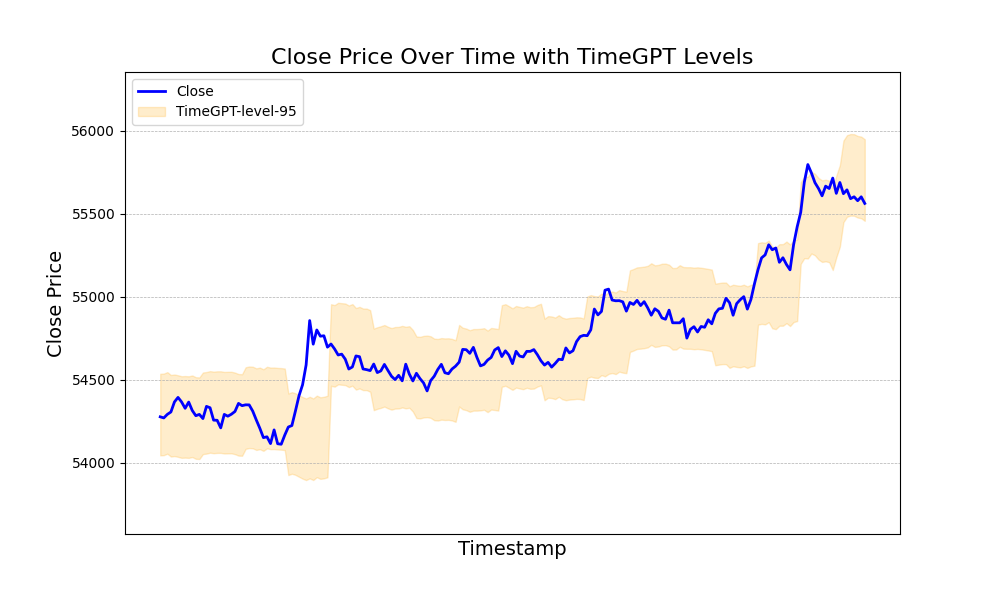

In [ ]:
ani = FuncAnimation(fig, animate, frames=200, interval=500, repeat=False)

plt.show()

/Users/fedex/miniconda3/envs/nixtlats/lib/python3.10/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


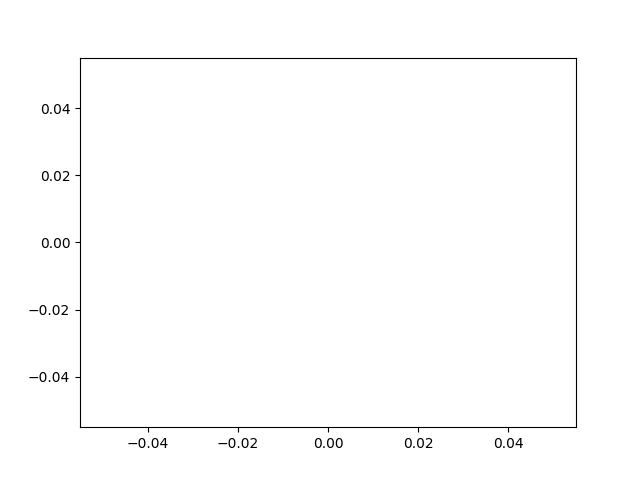

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'r-')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)

plt.show()


In [ ]:
ani.save('animation.mp4', writer='ffmpeg', fps=30)


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4